### Что та tools и зачем нужны
Модель как правило ничего не знает про сегодняшний контекст, потому что в её веса не заложили информацию о том, какой сейчас
курс доллара. Но она может узнавать это через tools
Tool - это тоже **Runnable**

Основные инструменты

1. Встроенные в Langchain:
- Tools (импортируем и пользуем Wikipedia, веб-поиск и прочее)
- Toolkits - ящики инструментов (SQLToolkit, GitHubToolkit)
2. Самописные инструменты
3. Инструменты от вендоров моделей:
- OpenAI
- Google
- Anthropic
- 
*дорого

In [1]:
import os
from getpass import getpass
from langchain_openai import ChatOpenAI

course_api_key = getpass(prompt='Введите API-ключ полученный в боте')

# инициализируем языковую модель
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini', 
                 base_url="https://aleron-llm.neuraldeep.tech/")

In [2]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

#Импортируем обертку для доступа к API
api_wrapper = WikipediaAPIWrapper(top_k_results=1 #Сколько результатов поиска выводить
                                  ,doc_content_chars_max=134 #Максимальная длина ответа
                                  )

#Инициализация
tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
#Запускаем запрос
answer =tool.invoke({'query': "Earth"})
print(answer)

# Page: Earth
# Summary: Earth is the third planet from the Sun and the only astronomical object known to harbor life. This is enabled by

Page: Earth
Summary: Earth is the third planet from the Sun and the only astronomical object known to harbor life. This is enabled by 


### Load_tools
Как говорил выше можно подгружать инструменты по ключевому имени из модуля

In [4]:
from langchain.agents import load_tools

#Установи pip install numexpr
#Гружу тулы для википедии и математики
tools = load_tools(["wikipedia", "llm-math"], llm = llm)

print(f'Тип: {type(tools)}. Количество: {len(tools)}')
#Тип: <class 'list'>. Количество: 2

Тип: <class 'list'>. Количество: 2


In [5]:
#Посмотрим что в туле
tools[0] #Экземпляр тула

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\Khabarov\\Репозиторий\\llm_practice_course\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [6]:
#Можно посмотреть основные поля
tools[1].name, tools[1].description

#('Calculator', 'Useful for when you need to answer questions about math.')

('Calculator', 'Useful for when you need to answer questions about math.')

In [7]:
#Проверим наш тул (да, можно в него кидать запросы)
tools[1].invoke('''У Маши было 3 яблока, Гриша принёс ещё 2 с половиной ящика яблок.
            Сколько всего яблок у ребят, если ящик вмещает 8 яблок?''')

#'Answer: 23.0' - Отвечает верно

'Answer: 23.0'

### Самописные инструменты через Tool и StructuredTool
В Langchain есть два типа инструментов:
- класс Tool принимает 1 аргумент на вход
- класс StructuredTool - любое число аргов

In [8]:
# Напишем функцию, которая считает количество символов в слове
def word_len(word):
    return len(word)
    
word_len('langchain')

9

In [9]:
from langchain_core.tools import Tool, StructuredTool

#Создаем свой tool который считает длину слов
word_len_tool = Tool(name="Word Length"
                     ,func=word_len
                     ,description="Считает количество символов в слове")

word_len_tool 
#Tool(name='Word Length', description='Считает количество символов в слове',
#  func=<function word_len at 0x0000013077BE3EC0>)

answer = word_len_tool.invoke("Большие бабки")
print(answer) #13

13


In [10]:
#Теперь создадим StructuredTool
# Добавим к функции несколько аргументов, и аннотации типов
def word_len_plus(word: str, b: int, g: int) -> int:
    """Считает количество символов в слове и прибавляет к ним числа""" # Обязательно добавляем docstring
    return len(word) + b - g

#Описание и название подхватывает из docstring
word_len_tool_plus = StructuredTool.from_function(func=word_len_plus)

answer = word_len_tool_plus.invoke({'word': 'LLM', 'b': 2, 'g': 3})
print(answer)

2


In [11]:
#Декоратор tool позволяет нам не думать о количестве аргументов, он сам определит

from langchain_core.tools import tool

@tool
def summ(a: int, b: int) -> int:
    """Складывает 2 целых числа"""
    return a + b

print(summ.name)
print(summ.description)
print(summ.args)

# summ
# Складывает 2 целых числа
# {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}

summ
Складывает 2 целых числа
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [12]:
summ # Декоратор сам определил, что это StructuredTool

StructuredTool(name='summ', description='Складывает 2 целых числа', args_schema=<class 'langchain_core.utils.pydantic.summ'>, func=<function summ at 0x00000284EC1C6980>)

### Tools Calling
Не все модели поддерживают вызов тулов. Но если поддерживает, то выглядит это так:
- модель получает запрос и пытается понять какой тул ей использовать (или не использовать никакой)
- сама вытаскивает из запроса аргументы для туда и передает в тул (или отвечает без тула)
- выдает ответ с использованием тула

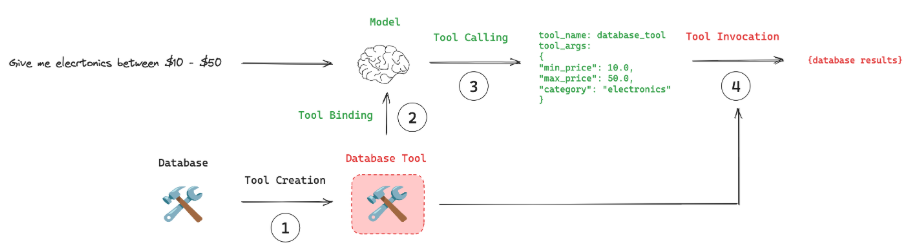

In [13]:
# Tool binding / привязка инструмента к LLM
model_with_tools = llm.bind_tools([summ])

# Tool calling 
response = model_with_tools.invoke("Сколько будет двадцать два плюс 17?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6kZCArlSCQMCFELEjfJp7qGD', 'function': {'arguments': '{"a":22,"b":17}', 'name': 'summ'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 59, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-Bw8E7pSrUKDtq2V6nusKPkzgDGgxo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0d45bd4-e1d1-4109-b5ec-7c2c4df2679a-0', tool_calls=[{'name': 'summ', 'args': {'a': 22, 'b': 17}, 'id': 'call_6kZCArlSCQMCFELEjfJp7qGD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 18, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'o

In [ ]:
#Теперь из нашего запроса можем достать tool_calls (чтобы посмотреть ходила ли ллм к тулам)
response.tool_calls

# [{'name': 'summ',
#   'args': {'a': 22, 'b': 17},
#   'id': 'call_6kZCArlSCQMCFELEjfJp7qGD',
#   'type': 'tool_call'}]

#Видим что модель правильно определила нужный тул и сама вычленила параметры для ввода

[{'name': 'summ',
  'args': {'a': 22, 'b': 17},
  'id': 'call_6kZCArlSCQMCFELEjfJp7qGD',
  'type': 'tool_call'}]

In [ ]:
#Получаем ответ через tool
tool_answer = summ.invoke(response.tool_calls[0])
tool_answer

#В нем хранится нужный нам ответ

ToolMessage(content='39', name='summ', tool_call_id='call_6kZCArlSCQMCFELEjfJp7qGD')

In [ ]:
# Спросим нейтральный вопрос - модель выдала ответ, tool_calls не было.
answer = model_with_tools.invoke("Сколько букв в слове зачёт?").content
answer #'В слове "зачёт" 6 букв.'

#Модель отвечает неправильно. Поможем ей через Tool

'В слове "зачёт" 6 букв.'

In [19]:
@tool
def get_word_length(word: str) -> int:
    """Возвращает длину слова""" # добавляем docstring, чтобмы LLM понимала суть инструмента
    return len(word)

tools = [get_word_length]

In [ ]:
# Tool binding
model_with_tools = llm.bind_tools(tools)

# Tool calling 
resp = model_with_tools.invoke("Сколько букв в слове зачёт?")
resp.tool_calls

#Видим, что модель правильно поняла какой тул использовать

[{'name': 'get_word_length',
  'args': {'word': 'зачёт'},
  'id': 'call_nHKeeVDSaExz66SbdgbPbqKu',
  'type': 'tool_call'}]

In [ ]:
from langchain_core.messages import HumanMessage

#Здесь мы получаем инфу о том какой тул использовался и какой ответ получился
tool_message = get_word_length.invoke(resp.tool_calls[0])
tool_message


# теперь соберём все сообщения вместе 
# важно чтобы id в tool_calling и ToolMessage совпадали.
messages = [
    HumanMessage("Сколько букв в слове зачёт?"),
    resp,
    tool_message
]

final_answer = model_with_tools.invoke(messages).content
final_answer

#Теперь модель отвечает верно 'В слове "зачёт" 5 букв.'

'В слове "зачёт" 5 букв.'

### Используем сразу несколько тулов

In [23]:
import datetime

# Создадим инструмент, показывающий текущее время
@tool
def get_current_time(nothing: None ) -> str:
    """Возвращает текущее время""" 

    # Получаем текущее время и дату
    now = datetime.datetime.now()
    
    # Возвращаем текущее время
    return now.strftime('%H:%M:%S')

# Загрузим готовые инструменты
tools = load_tools(["wikipedia",
                    "llm-math"], llm=llm)

In [24]:
# Привязка инструментов к LLM
llm_with_tools = llm.bind_tools(tools + [get_current_time])

In [ ]:
task = "Извлеки квадратный корень из девяти и назови количество участников группы Beatles. А еще скажи время"

messages = [HumanMessage(task)]
print(messages[0])

#content='Извлеки квадратный корень из девяти и назови количество участников группы Beatles.
#  А еще скажи время' additional_kwargs={} response_metadata={}

content='Извлеки квадратный корень из девяти и назови количество участников группы Beatles. А еще скажи время' additional_kwargs={} response_metadata={}


In [ ]:
#Получаем отклик от модели
response = llm_with_tools.invoke(messages)



{'tool_calls': [{'id': 'call_EVe628c7Arb3q4vacos1RREW', 'function': {'arguments': '{"__arg1": "sqrt(9)"}', 'name': 'Calculator'}, 'type': 'function'}, {'id': 'call_D08GBnifHCTdTYBboFTvJe23', 'function': {'arguments': '{"query": "The Beatles"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_vlr4Dx1mDPGk8alRhwNFNZEG', 'function': {'arguments': '{"nothing": null}', 'name': 'get_current_time'}, 'type': 'function'}], 'refusal': None}


In [ ]:
print(response.additional_kwargs)

{'tool_calls': 
 [{'id': 'call_EVe628c7Arb3q4vacos1RREW', 'function': {'arguments': '{"__arg1": "sqrt(9)"}', 'name': 'Calculator'}, 'type': 'function'},
   {'id': 'call_D08GBnifHCTdTYBboFTvJe23', 'function': {'arguments': '{"query": "The Beatles"}', 'name': 'wikipedia'}, 'type': 'function'},
     {'id': 'call_vlr4Dx1mDPGk8alRhwNFNZEG', 'function': {'arguments': '{"nothing": null}', 'name': 'get_current_time'}, 'type': 'function'}],
       'refusal': None}

#Здесь можно увидеть, что наша модель обращалась к 3м тулам с разными аргументами


{'tool_calls': [{'id': 'call_EVe628c7Arb3q4vacos1RREW', 'function': {'arguments': '{"__arg1": "sqrt(9)"}', 'name': 'Calculator'}, 'type': 'function'}, {'id': 'call_D08GBnifHCTdTYBboFTvJe23', 'function': {'arguments': '{"query": "The Beatles"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_vlr4Dx1mDPGk8alRhwNFNZEG', 'function': {'arguments': '{"nothing": null}', 'name': 'get_current_time'}, 'type': 'function'}], 'refusal': None}


In [31]:
print(response.tool_calls) #Можно еще чекнуть так

[{'name': 'Calculator', 'args': {'__arg1': 'sqrt(9)'}, 'id': 'call_EVe628c7Arb3q4vacos1RREW', 'type': 'tool_call'}, {'name': 'wikipedia', 'args': {'query': 'The Beatles'}, 'id': 'call_D08GBnifHCTdTYBboFTvJe23', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {'nothing': None}, 'id': 'call_vlr4Dx1mDPGk8alRhwNFNZEG', 'type': 'tool_call'}]


In [32]:
messages.append(response)

#Наш список messages - это HumanMessage, а затем AIMessage (он же response)

In [33]:
# Соберём ToolMessages в messages
for tool_call in response.tool_calls:

    if tool_call["name"] == 'wikipedia':
        tool_msg = tools[0].invoke(tool_call)
        
    elif tool_call["name"] == 'get_current_time':
        tool_msg = get_current_time.invoke(tool_call)
        
    else:
        tool_msg = tools[1].invoke(tool_call)
        
    messages.append(tool_msg)

In [ ]:
messages #Теперь тут у нас есть все сообщения (1 вопрос, 2 общий ответ, 3 - 5 частные ответы)

[HumanMessage(content='Извлеки квадратный корень из девяти и назови количество участников группы Beatles. А еще скажи время', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EVe628c7Arb3q4vacos1RREW', 'function': {'arguments': '{"__arg1": "sqrt(9)"}', 'name': 'Calculator'}, 'type': 'function'}, {'id': 'call_D08GBnifHCTdTYBboFTvJe23', 'function': {'arguments': '{"query": "The Beatles"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_vlr4Dx1mDPGk8alRhwNFNZEG', 'function': {'arguments': '{"nothing": null}', 'name': 'get_current_time'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 159, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-

In [ ]:
print(llm_with_tools.invoke(messages).content)

#Модель ответила на все 3 вопроса

Квадратный корень из девяти равен 3.0.

Группа Beatles состояла из четырех участников: Джона Леннона, Пола Маккартни, Джорджа Харрисона и Ринго Старра.

Текущее время: 19:54:17.
